In [4]:
import os
import math
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


In [5]:
image_file_name = 'image2.png' # 나의 사진파일 이름
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/'+ image_file_name #이미지 경로설정
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

In [6]:
detector_hog = dlib.get_frontal_face_detector()  # face detection 할당

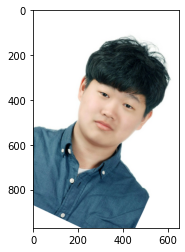

In [7]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)  # 이미지 대기
plt.show()  # 이미지 표시
dlib_rects = detector_hog(img_rgb, 1)   # (저장된 이미지(변수), num of image pyramid)

rectangles[[(200, 320) (468, 587)]]


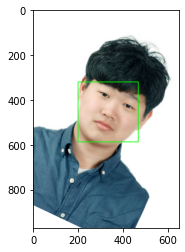

In [8]:
print(dlib_rects)   

for dlib_rect in dlib_rects:  # detector_hog(img_rgb, 1) dlib.rectangle의 객체 left(), top(), right(), bottom(), height(), width()
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # cv2로 사각형 그리기

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)  # 수정한 이미지 변환후 저장
plt.imshow(img_show_rgb)  # 이미지 대기
plt.show()  # 이미지 대기

In [9]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat' # 모델 경로설정
landmark_predictor = dlib.shape_predictor(model_path)  #dlib 랜드마크 모델 할당

In [10]:
list_landmarks = []

# 얼굴 영역에서 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # 이미지로 face landmark 위치(좌표) 만들기
    temp = list(map(lambda p: (p.x, p.y), points.parts())) # face landmark x, y 좌표를 임시 저장
    list_landmarks.append(temp)  # temp로 임시저장된 좌표를 0번인덱스에 한꺼번에 넣기!
    
print(len(list_landmarks[0]))

68


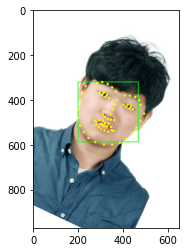

In [11]:
for i in range(len(list_landmarks[0])):  # 점을 랜드마크 갯수만큼 찍어줘야 함!
        x, y = list_landmarks[0][i]  # 저장해둔 좌표값 써먹기.
        cv2.circle(img_show, (x, y), 5, (0, 255, 255), -1)  # 이미지에 좌표에 따라 점 찍기

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)  # 수정한 이미지 변환후 저장
plt.imshow(img_show_rgb)  # 이미지 대기
plt.show()  # 이미지 출력

In [12]:

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):  # zip 함수를 통해 동시에 두가지 list 불러오기 
    angle = math.atan((landmark[19][1] - landmark[24][1]) / (landmark[19][0] - landmark[24][0])) * 180 / math.pi # 얼굴 기울기 계산을 위해 눈위의 평행점 좌표 사용
    x = landmark[33][0]  # 이미지를 표시할 좌표 x
    y = landmark[33][1] + (landmark[51][1]-landmark[33][1]) // 2 - 5  # 이미지를 표시할 좌표 y (이미지 높이를 33과 51사이에 넣기 위해 좌표값을 빼고 나눔)
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (332,488)
(w,h) : (269,269)


In [13]:
# 스티커 이미지 경로
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
sticker_path_rotated = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers_rotated.png'
# 이미지 손실없이 회전위해 PIL로 불러와서 회전한 이미지를 다시 저장
img_sticker = Image.open(sticker_path) # 경로에서 이미지 불러오기
img_sticker = img_sticker.rotate(-angle,fillcolor='white', expand=True)  # 회전과 배경 채우기
img_sticker.save(sticker_path_rotated)  # 저장

img_sticker = cv2.imread(sticker_path_rotated) # 스티커 이미지를 다시 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 이미지 크기 조절하기

In [14]:
# 이미지의 왼쪽 위가 랜드마크의 좌표로 설정 되어 있기 때문에 이미지 x, y 재설정
# 이미지가 중간이 좌표의 중간과 일치하도록 위치설정, 난해하게 움직일 바에는 중간에서 시작.
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (198,354)


In [15]:
# 이미지 위치가 음수일 경우 이미지를 자름
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

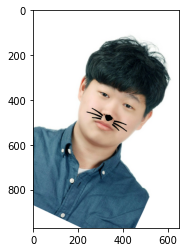

In [16]:
# 스티커 하얀색 배경 제거 (일종의 마스크?)
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
# 결과값 표시
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
얼굴 각도에 따른 스티커 설정에 관해서 코딩 하는중 이미지 파일을 돌리는것에 검은 배경이 뒤따르 문제가 개선하는게 힘들었는데 PIL을 사용해서 손쉽게 해결 할 수 있었다 좌표값을 아니 각도를 계산하는 공식은 생각보다 간단하게 주변 사람들에게 알아 볼 수 있어서 구상 자체에 더 시간이 걸린것 같다! 멀리서 촬영 ,옆으로 누워서 촬영에 대해서도 해결방법을 구현 하고 싶었는데 시간 관계상 다음 기회로 미루었다 ㅠㅠ


# 문제점에 관하여

## 얼굴 각도

스티커가 생성되는 기준이 수직, 수평에 맞춰서 있어서 얼굴 각도가 반영이 되어있지 않다.  
따라서 스티커를 생성할때 각도도 반영해야 해야함.
landmark 19번, 24번의 좌표를 이용해서 현재 얼굴의 기울기를 계산한 후에  
math.atan함수를 이용한 공식으로 간편하게 계산하였었는데 테스트를 해보니 19번, 24번(눈썹?)은 너무 오차가 커서  
상대적 평행인 선들 중에는 59, 55번이 가장 오차가 적어 변경 하였다. 
본인은 수학에 손을뗀지 오래되어 공식은 친구의 도움을 받았다;;
### * 여러가지 사진 테스트, 스티커 각도 조정 등은 Camera_Sticker for test.ipynb 에서 진행 하였다.
## 멀리서 촬영 ,옆으로 누워서 촬영
여러 사진으로 테스트 해보았는데 멀리서 촬영하거나 옆으로 누워서 촬영시에는 눈 코 입을 인식하기 힘들기 때문으로 보임 그리고 이는 랜드마크를 찾지 못했을때 랜드마크가 나올때까지 사진의 각도를 자동적으로 변경하게끔 해주면 해결될듯 함
## 실행 속도
실행 속도가 느리면 일반 사진 촬영에서는 불편함을 느끼기 힘들겠지만 웹캠, 영상통화 등의 실시간 기능을 추가하려면 반드시 개선해야 할 점이고 
https://www.pyimagesearch.com/2018/04/02/faster-facial-landmark-detector-with-dlib/ 이 링크에 설명되어있는것처럼 5개의 특징점 만으로 랜드마크를 표시 할 수 있게 된다면 실행 속도는
크게 개선될듯 하지만 정확도 면에서는 68개를 사용하는 기존의 알고리즘 보다 떨어질 듯 하다.
## 정확도
정확도가 낮으면 사람이 아닌 사물이나 동물들을 눈코입만 달려있으면 인식하게되는 기현상이 나타날 수도 있을것이고 이렇게되면 도저희 적용할 수가 없을것으로 생각된다.
(위의 5개의 특징점을 이용한 알고리즘은 그정도는 아니겠지만;;)
